### Simulation of ground-based sky radiance observations (e.g. AERONET)

This example demonstrates how eradiate can be used to simulate ground-based radiometers, e.g. the CIMEL Electronique CE318 multiband sun photometer that performs measurements of spectral sun irradiance and sky radiances and is the instrument used in AERONET. 



In [ ]:
import eradiate
import matplotlib.pyplot as plt
import numpy as np
from eradiate import scenes as ertsc
from eradiate import unit_registry as ureg

In the following we calculate the radiance at a particular wavelength and select the mode "mono_polarized" which fully takes into account polarization. For simulations neglecting polarization select "mono".

List all available modes with ```eradiate.modes()```.

In [ ]:
eradiate.set_mode("mono_polarized")

### Definition of a standard atmosphere

Standard atmospheres (e.g. tropical, midlatitude summer, midlatitude winter, subarctic summer, subarctic winter, US standard atmosphere 1976) are included in the joseki package and can be included as follows: 

In [ ]:
usstd = ertsc.atmosphere.MolecularAtmosphere(
    thermoprops={
        "identifier": "afgl_1986-us_standard",
        "z": np.linspace(0.0, 120.0, 121) * ureg.km,
    },
)

### Definition of aerosols

Define a standard aerosol layer from 0 to 2 km using the desert aerosol type as defined by Govaerts 2021. The optical thickness is 0.5. 

In [ ]:
particle_layer = ertsc.atmosphere.ParticleLayer(
    tau_ref=0.5,
    bottom=0 * ureg.m,
    top=2 * ureg.km,
    distribution="uniform",
    w_ref=350 * ureg.nm,
    dataset="govaerts_2021-desert-extrapolated",
)

### Merge molecules and particle layer in atmosphere structure

In [ ]:
atmosphere = ertsc.atmosphere.HeterogeneousAtmosphere(
    molecular_atmosphere=usstd, particle_layers=[particle_layer]
)

### Observation geometry

Specify the sensor: set up observation geometries for the almucantar plane and include the center wavelength of CE318.

In [ ]:
wavelength = np.array([340, 380, 440, 500, 675, 870, 937, 1020, 1640]) * ureg.nm

# almucantar plane
vza = [np.array([30.0])]
vaa = np.arange(0.0, 181.0, 5.0) * ureg.deg

layout = eradiate.scenes.measure.GridLayout(
    zeniths=vza,
    azimuths=vaa,
)

origins = np.zeros_like(layout.directions) + 0.00001

measure = ertsc.measure.MultiRadiancemeterMeasure(
    id="almucantar",
    origins=origins,
    directions=layout.directions,
    srf={"type": "multi_delta", "wavelengths": wavelength},
)

### Define an AtmosphereExperiment

All is put together in a eradiate "experiment". In addition the surface (here Lambertian) and the sun position need to be inlcuded.

In [ ]:
def run_exp(spp, measure, atmosphere, integrator=None):
    """
    Run almucanter scan.
    """

    if integrator is None:
        integrator = ertsc.integrators.VolPathIntegrator()

    exp = eradiate.experiments.AtmosphereExperiment(
        surface={
            "type": "lambertian",
            "reflectance": 0.05,
        },
        illumination={
            "type": "directional",
            "zenith": 30,
            "azimuth": 0,
            "irradiance": 1.0,
        },
        atmosphere=atmosphere,
        measures=measure,
        integrator=integrator,
    )

    exp.integrator.stokes = True
    exp.integrator.meridian_align = True

    return eradiate.run(exp, spp=spp)

### Run eradiate

In [ ]:
result_eradiate = run_exp(spp=100000, measure=measure, atmosphere=atmosphere)

### Plot the results

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

labels = ["I", "Q", "U", "V"]
wavelengths = result_eradiate["w"].values

for idx in range(3):
    axs[idx].set_xlabel("vaa [deg]")
    axs[idx].set_ylabel(labels[idx])
    axs[idx].set_title(labels[idx])
    for w_idx, wl in enumerate(wavelengths):
        axs[idx].plot(
            vaa,
            result_eradiate["radiance"].data[w_idx, idx, 0, :, 0, 0],
            label=f"{int(wl)} nm" if idx == 0 else None,
        )
    if idx == 0:
        axs[idx].legend(title="Wavelength")

# Degree of polarization for each wavelength
for w_idx, wl in enumerate(wavelengths):
    dop = np.sqrt(
        result_eradiate["radiance"].data[w_idx, 1, 0, :, 0, 0] ** 2
        + result_eradiate["radiance"].data[w_idx, 2, 0, :, 0, 0] ** 2
        + result_eradiate["radiance"].data[w_idx, 3, 0, :, 0, 0] ** 2
    ) / np.abs(result_eradiate["radiance"].data[w_idx, 0, 0, :, 0, 0])
    axs[3].plot(vaa, dop, label=f"{int(wl)} nm")
axs[3].set_xlabel("vaa [deg]")
axs[3].set_ylabel("DoP")
axs[3].set_title("Degree of Polarization")

plt.tight_layout()
plt.show()

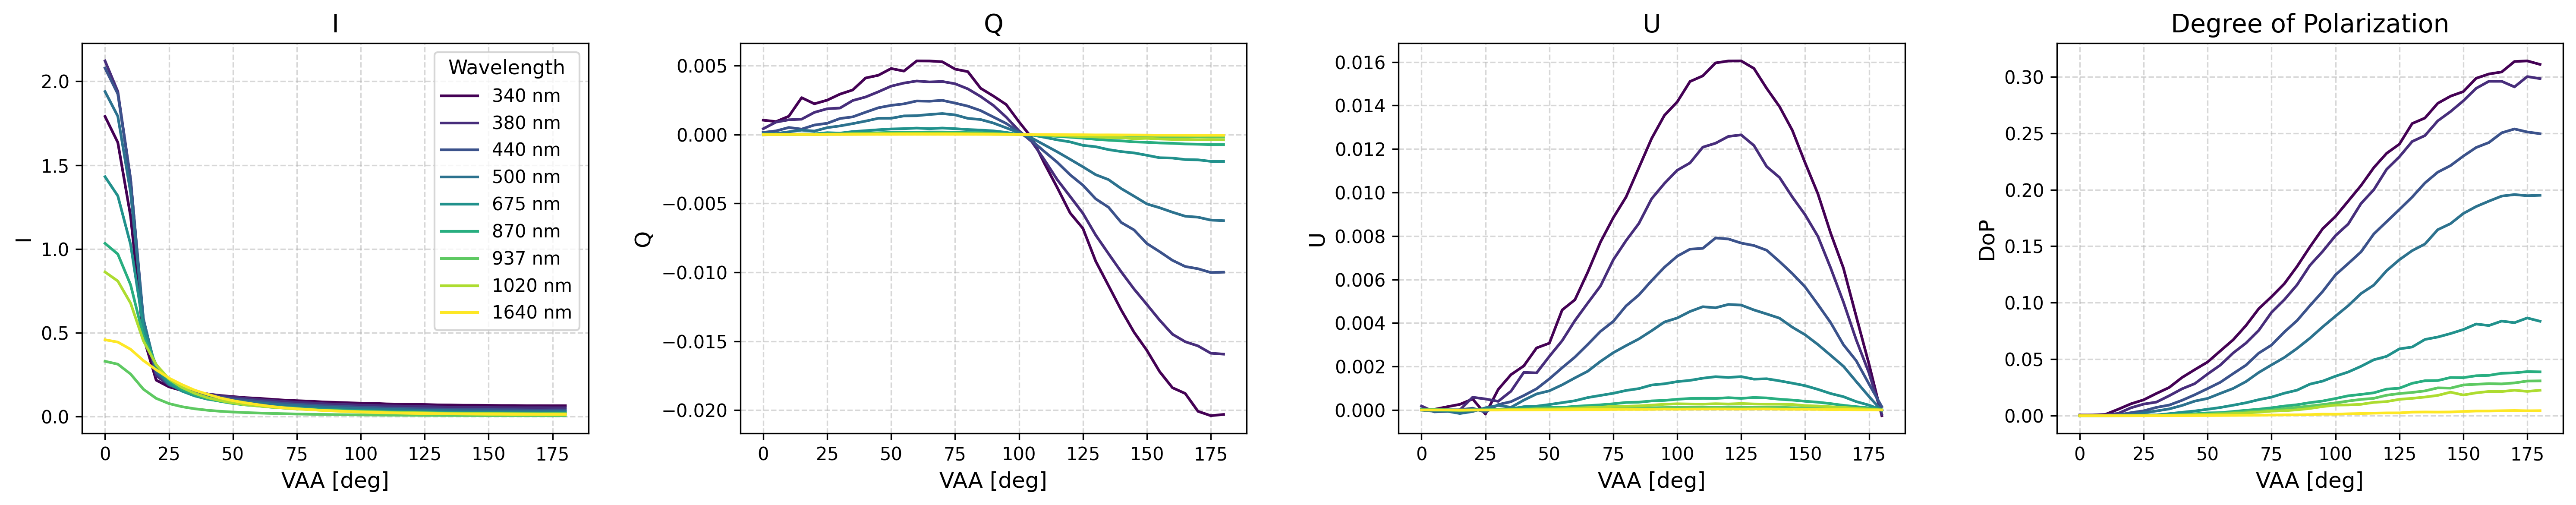

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

fig, axs = plt.subplots(1, 4, figsize=(20, 4), dpi=300)

labels = ['I', 'Q', 'U', 'V']
wavelengths = result_eradiate['w'].values
colors = cm.viridis(np.linspace(0, 1, len(wavelengths)))

for idx in range(3):
    axs[idx].set_title(labels[idx], fontsize=14)
    axs[idx].set_xlabel('VAA [deg]', fontsize=12)
    axs[idx].set_ylabel(labels[idx], fontsize=12)
    axs[idx].grid(True, linestyle='--', alpha=0.5)

    for w_idx, wl in enumerate(wavelengths):
        axs[idx].plot(
            vaa,
            result_eradiate['radiance'].data[w_idx, idx, 0, :, 0, 0],
            label=f'{int(wl)} nm' if idx == 0 else None,
            color=colors[w_idx],
            linewidth=1.5
        )
    if idx == 0:
        axs[idx].legend(title='Wavelength', fontsize=10, title_fontsize=11, loc='best')

# Degree of polarization plot
axs[3].set_title('Degree of Polarization', fontsize=14)
axs[3].set_xlabel('VAA [deg]', fontsize=12)
axs[3].set_ylabel('DoP', fontsize=12)
axs[3].grid(True, linestyle='--', alpha=0.5)

for w_idx, wl in enumerate(wavelengths):
    I = result_eradiate['radiance'].data[w_idx, 0, 0, :, 0, 0]
    Q = result_eradiate['radiance'].data[w_idx, 1, 0, :, 0, 0]
    U = result_eradiate['radiance'].data[w_idx, 2, 0, :, 0, 0]
    V = result_eradiate['radiance'].data[w_idx, 3, 0, :, 0, 0]

    dop = np.sqrt(Q**2 + U**2 + V**2) / np.abs(I)
    axs[3].plot(vaa, dop, label=f'{int(wl)} nm', color=colors[w_idx], linewidth=1.5)

# Optional: legend for DoP only if needed
# axs[3].legend(title='Wavelength', fontsize=10, title_fontsize=11, loc='best')

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)  # more space between subplots
plt.show()


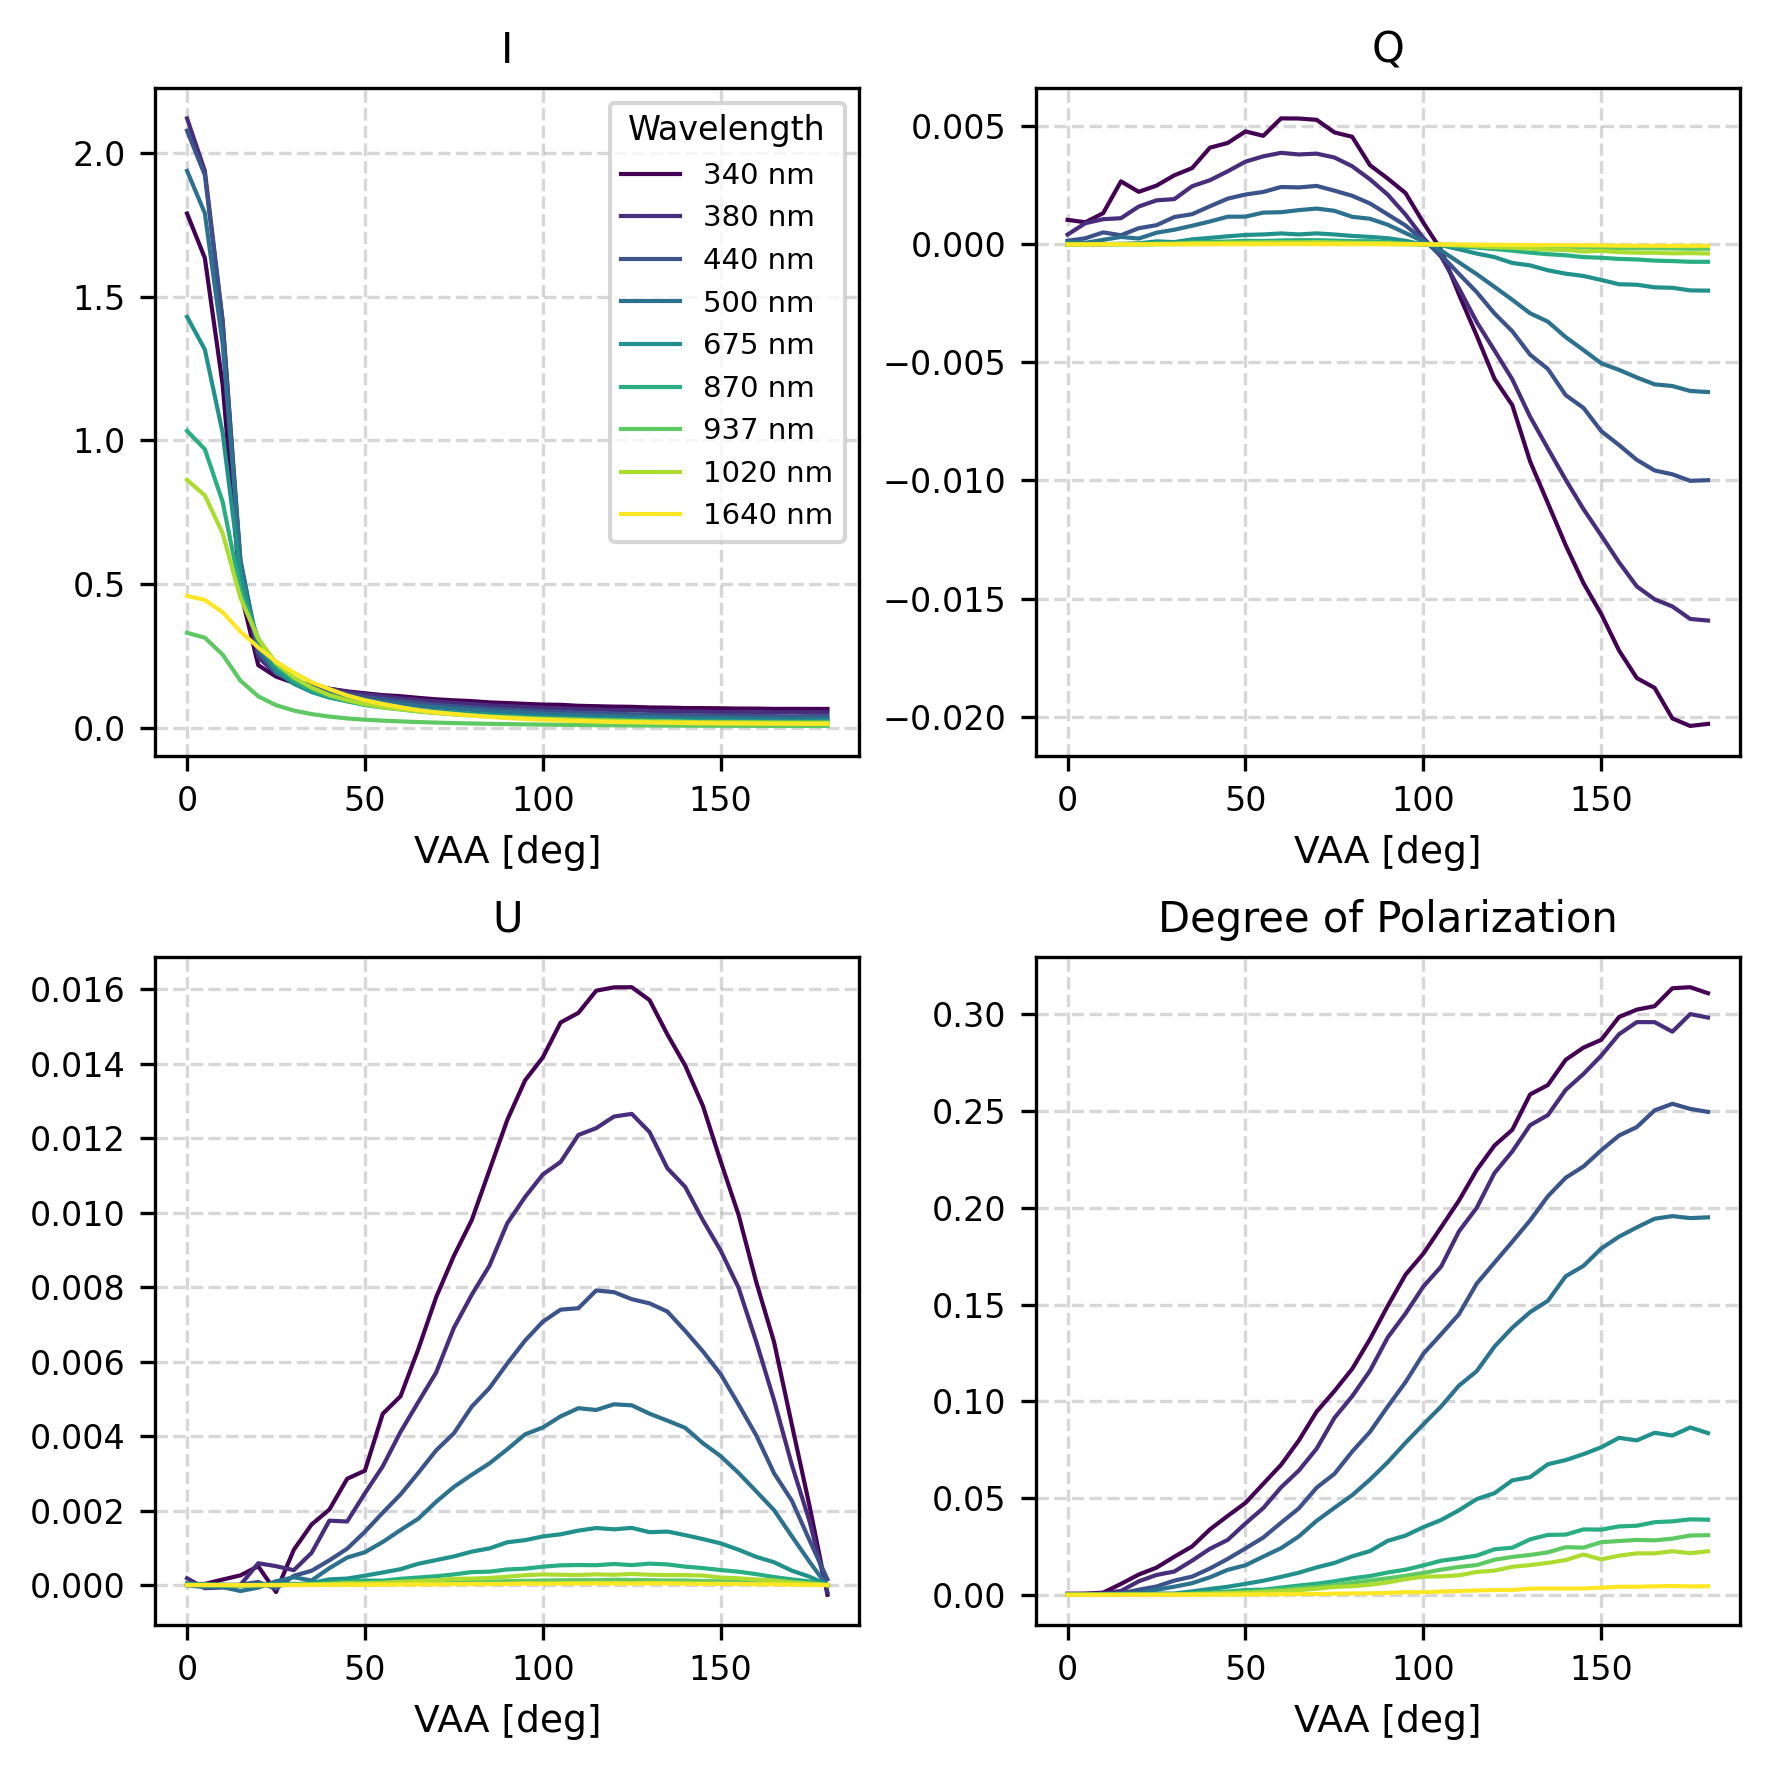

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), dpi=300)

labels = ['I', 'Q', 'U', 'Degree of Polarization']
ylabels = ['I', 'Q', 'U', 'DoP']
wavelengths = result_eradiate['w'].values
colors = cm.viridis(np.linspace(0, 1, len(wavelengths)))

# Flatten axs for easy indexing
axs = axs.flatten()

for idx in range(3):
    axs[idx].set_title(labels[idx], fontsize=10)
    axs[idx].set_xlabel('VAA [deg]', fontsize=9)
    #axs[idx].set_ylabel(ylabels[idx], fontsize=9)
    axs[idx].tick_params(axis='both', labelsize=8)
    axs[idx].grid(True, linestyle='--', alpha=0.5)
    for w_idx, wl in enumerate(wavelengths):
        axs[idx].plot(
            vaa.magnitude,
            result_eradiate['radiance'].data[w_idx, idx, 0, :, 0, 0],
            label=f'{int(wl)} nm' if idx == 0 else None,
            color=colors[w_idx],
            linewidth=1
        )
    if idx == 0:
        axs[idx].legend(title='Wavelength', fontsize=7, title_fontsize=8, loc='best')

# Degree of polarization plot
axs[3].set_title(labels[3], fontsize=10)
axs[3].set_xlabel('VAA [deg]', fontsize=9)
#axs[3].set_ylabel(ylabels[3], fontsize=9)
axs[3].tick_params(axis='both', labelsize=8)
axs[3].grid(True, linestyle='--', alpha=0.5)
for w_idx, wl in enumerate(wavelengths):
    I = result_eradiate['radiance'].data[w_idx, 0, 0, :, 0, 0]
    Q = result_eradiate['radiance'].data[w_idx, 1, 0, :, 0, 0]
    U = result_eradiate['radiance'].data[w_idx, 2, 0, :, 0, 0]
    V = result_eradiate['radiance'].data[w_idx, 3, 0, :, 0, 0]
    dop = np.sqrt(Q**2 + U**2 + V**2) / np.abs(I)
    axs[3].plot(vaa.magnitude, dop, label=f'{int(wl)} nm', color=colors[w_idx], linewidth=1)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.25)
plt.savefig('sunphotometer_almucantar.pdf', bbox_inches='tight', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>